In [1]:
#Final code of the project to detect damaged tissues on the lung

In [2]:
#importing libraries as needed
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import os.path
from pathlib import Path
import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import warnings
warnings.filterwarnings('ignore')
from PIL import Image 
from PIL.ImageDraw import Draw

#from keras.models import load_model
#import keras
#from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D

In [3]:
import tensorflow as tf

In [4]:
#read in csv files
csv_path = 'csv_files/'
df_image_id = pd.read_csv(csv_path + 'nih-cxr-lt_image_ids.csv')
df_label_train = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_train.csv')
df_label_test = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_test.csv')
df_balanced_test = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_balanced-test.csv')
df_balanced_val = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_balanced-val.csv')
#there are 5 files:
#all image ids
#balanced testing dataset
#balanced validation dataset
#normal testing dataset
#normal training dataset

#fixing naming convention of a columns
df_label_train.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_label_train.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_label_train.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_label_train.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)
df_label_test.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_label_test.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_label_test.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_label_test.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)
df_balanced_test.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_balanced_test.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_balanced_test.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_balanced_test.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)
df_balanced_val.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_balanced_val.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_balanced_val.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_balanced_val.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)

#create new dataframes that contain solely heart issues
#include columns only with heart related labels
#remove rows where all values are zero (no finding == 0 -> condition)
#cant do one liner for dropping so have to use conditional drop
df_label_train_heart = df_label_train[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_label_train_heart = df_label_train_heart.drop(df_label_train_heart[(df_label_train_heart.Cardiomegaly == 0) & (df_label_train_heart.Infiltration == 0) & (df_label_train_heart.Mass == 0) & (df_label_train_heart.Nodule == 0) & (df_label_train_heart.Tortuous_Aorta == 0) & (df_label_train_heart.Calcification_of_the_Aorta == 0) & (df_label_train_heart.No_Finding == 0) ].index)
df_label_test_heart = df_label_test[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_label_test_heart = df_label_test_heart.drop(df_label_test_heart[(df_label_test_heart.Cardiomegaly == 0) & (df_label_test_heart.Infiltration == 0) & (df_label_test_heart.Mass == 0) & (df_label_test_heart.Nodule == 0) & (df_label_test_heart.Tortuous_Aorta == 0) & (df_label_test_heart.Calcification_of_the_Aorta == 0) & (df_label_test_heart.No_Finding == 0) ].index)
df_balanced_test_heart = df_balanced_test[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_balanced_test_heart = df_balanced_test_heart.drop(df_balanced_test_heart[(df_balanced_test_heart.Cardiomegaly == 0) & (df_balanced_test_heart.Infiltration == 0) & (df_balanced_test_heart.Mass == 0) & (df_balanced_test_heart.Nodule == 0) & (df_balanced_test_heart.Tortuous_Aorta == 0) & (df_balanced_test_heart.Calcification_of_the_Aorta == 0) & (df_balanced_test_heart.No_Finding == 0) ].index)
df_balanced_val_heart = df_balanced_val[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_balanced_val_heart = df_balanced_val_heart.drop(df_balanced_val_heart[(df_balanced_val_heart.Cardiomegaly == 0) & (df_balanced_val_heart.Infiltration == 0) & (df_balanced_val_heart.Mass == 0) & (df_balanced_val_heart.Nodule == 0) & (df_balanced_val_heart.Tortuous_Aorta == 0) & (df_balanced_val_heart.Calcification_of_the_Aorta == 0) & (df_balanced_val_heart.No_Finding == 0) ].index)
display(df_label_train_heart)

# #create new dataframes that contain solely lung issues (what we are currently concerned with)
# #include columns only with lung related labels
# #remove rows where all values are zero
df_label_train_lung = df_label_train[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_label_train_lung = df_label_train_lung.drop(df_label_train_lung[(df_label_train_lung.Atelectasis == 0) & (df_label_train_lung.Consolidation == 0) & (df_label_train_lung.Edema == 0) & (df_label_train_lung.Effusion == 0) & (df_label_train_lung.Emphysema == 0) & (df_label_train_lung.Fibrosis == 0) & (df_label_train_lung.Hernia == 0) & (df_label_train_lung.Infiltration == 0) & (df_label_train_lung.Mass == 0) & (df_label_train_lung.Nodule == 0) & (df_label_train_lung.Pleural_Thickening == 0) & (df_label_train_lung.Pneumonia == 0) & (df_label_train_lung.Pneumothorax == 0)& (df_label_train_lung.Pneumomediastinum == 0) & (df_label_train_lung.No_Finding == 0)].index)
df_label_test_lung = df_label_test[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_label_test_lung = df_label_test_lung.drop(df_label_test_lung[(df_label_test_lung.Atelectasis == 0) & (df_label_test_lung.Consolidation == 0) & (df_label_test_lung.Edema == 0) & (df_label_test_lung.Effusion == 0) & (df_label_test_lung.Emphysema == 0) & (df_label_test_lung.Fibrosis == 0) & (df_label_test_lung.Hernia == 0) & (df_label_test_lung.Infiltration == 0) & (df_label_test_lung.Mass == 0) & (df_label_test_lung.Nodule == 0) & (df_label_test_lung.Pleural_Thickening == 0) & (df_label_test_lung.Pneumonia == 0) & (df_label_test_lung.Pneumothorax == 0)& (df_label_test_lung.Pneumomediastinum == 0) & (df_label_test_lung.No_Finding == 0)].index)
df_balanced_test_lung = df_balanced_test[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_balanced_test_lung = df_balanced_test_lung.drop(df_balanced_test_lung[(df_balanced_test_lung.Atelectasis == 0) & (df_balanced_test_lung.Consolidation == 0) & (df_balanced_test_lung.Edema == 0) & (df_balanced_test_lung.Effusion == 0) & (df_balanced_test_lung.Emphysema == 0) & (df_balanced_test_lung.Fibrosis == 0) & (df_balanced_test_lung.Hernia == 0) & (df_balanced_test_lung.Infiltration == 0) & (df_balanced_test_lung.Mass == 0) & (df_balanced_test_lung.Nodule == 0) & (df_balanced_test_lung.Pleural_Thickening == 0) & (df_balanced_test_lung.Pneumonia == 0) & (df_balanced_test_lung.Pneumothorax == 0) & (df_balanced_test_lung.Pneumomediastinum == 0) & (df_balanced_test_lung.No_Finding == 0)].index)
df_balanced_val_lung = df_balanced_val[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_balanced_val_lung = df_balanced_val_lung.drop(df_balanced_val_lung[(df_balanced_val_lung.Atelectasis == 0) & (df_balanced_val_lung.Consolidation == 0) & (df_balanced_val_lung.Edema == 0) & (df_balanced_val_lung.Effusion == 0) & (df_balanced_val_lung.Emphysema == 0) & (df_balanced_val_lung.Fibrosis == 0) & (df_balanced_val_lung.Hernia == 0) & (df_balanced_val_lung.Infiltration == 0) & (df_balanced_val_lung.Mass == 0) & (df_balanced_val_lung.Nodule == 0) & (df_balanced_val_lung.Pleural_Thickening == 0) & (df_balanced_val_lung.Pneumonia == 0) & (df_balanced_val_lung.Pneumothorax == 0) & (df_balanced_val_lung.Pneumomediastinum == 0) & (df_balanced_val_lung.No_Finding == 0)].index)
display(df_label_train_lung)

#saving new dataframes
df_label_train_heart.to_csv(csv_path + 'label_train_heart.csv', index=False)
df_label_test_heart.to_csv(csv_path + 'label_test_heart.csv', index=False)
df_balanced_test_heart.to_csv(csv_path + 'balanced_test_heart.csv', index=False)
df_balanced_val_heart.to_csv(csv_path + 'balanced_val_heart.csv', index=False)
df_label_train_lung.to_csv(csv_path + 'label_train_lung.csv', index=False)
df_label_test_lung.to_csv(csv_path + 'label_test_lung.csv', index=False)
df_balanced_test_lung.to_csv(csv_path + 'balanced_test_lung.csv', index=False)
df_balanced_val_lung.to_csv(csv_path + 'balanced_val_lung.csv', index=False)

,id,Cardiomegaly,Infiltration,Mass,Nodule,Tortuous_Aorta,Calcification_of_the_Aorta,No_Finding,subject_id
0,00000001_000.png,1,0,0,0,0,0,0,1
1,00000002_000.png,0,0,0,0,0,0,1,2
2,00000005_000.png,0,0,0,0,0,0,1,5
3,00000005_001.png,0,0,0,0,0,0,1,5
4,00000005_002.png,0,0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...
68053,00030801_000.png,0,0,0,0,0,0,1,30801
68054,00030802_000.png,0,0,0,0,0,0,1,30802
68055,00030803_000.png,0,0,0,0,0,0,1,30803
68056,00030804_000.png,0,0,0,0,0,0,1,30804


,id,Atelectasis,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumomediastinum,No_Finding,subject_id
1,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
2,00000005_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
3,00000005_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
4,00000005_002.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
5,00000005_003.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68053,00030801_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30801
68054,00030802_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30802
68055,00030803_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30803
68056,00030804_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30804


In [5]:
#selecting wanted data values for predicting lung cancer (id, Mass, Nodule, No_Finding)
cancer_train = df_label_train_lung[(df_label_train_lung.Nodule == 1) | (df_label_train_lung.Mass == 1)] 
cancer_train_neg = df_label_train_lung[(df_label_train_lung.No_Finding == 1)]
cancer_val = df_balanced_val_lung[(df_balanced_val_lung.Nodule == 1) | (df_balanced_val_lung.Mass == 1)]
cancer_val_neg = df_balanced_val_lung[(df_balanced_val_lung.No_Finding == 1)]
cancer_test = df_label_test_lung[(df_label_test_lung.Nodule == 1) | (df_label_test_lung.Mass == 1)]
cancer_test_neg = df_label_test_lung[(df_label_test_lung.No_Finding == 1)]
#selecting only relevant columns 
cancer_train = cancer_train[['id', 'Mass', 'Nodule', 'No_Finding']]
cancer_train_neg = cancer_train_neg[['id', 'Mass', 'Nodule', 'No_Finding']]
cancer_val = cancer_val[['id', 'Mass', 'Nodule', 'No_Finding']]
cancer_val_neg = cancer_val_neg[['id', 'Mass', 'Nodule', 'No_Finding']]
cancer_test = cancer_test[['id', 'Mass', 'Nodule', 'No_Finding']]
cancer_test_neg = cancer_test_neg[['id', 'Mass', 'Nodule', 'No_Finding']]

In [6]:
#select range from each and append, then shuffle
train_add = cancer_train_neg[0:3701]
cancer_train = cancer_train.append(train_add)
cancer_train = cancer_train.sample(frac = 1)
val_add = cancer_val_neg[0:14]
cancer_val = cancer_val.append(val_add)
cancer_val = cancer_val.sample(frac = 1)
test_add = cancer_test_neg[0:1000]
cancer_test = cancer_test.append(test_add)
cancer_test = cancer_test.sample(frac = 1)

In [7]:
#consolidating the data and one hot encoding
conditions = [(cancer_train['No_Finding']==1),
              (cancer_train['No_Finding']==0)
             ]

values = [0, 1]
              
cancer_train['target'] = np.select(conditions, values)

encoded = pd.get_dummies(cancer_train['target'])
cancer_train = cancer_train.join(encoded)
cancer_train = cancer_train.drop(['Mass', 'Nodule', 'No_Finding', 'target'], axis=1)
cancer_train.rename(columns = {cancer_train.columns[1]:'cancer_negative', cancer_train.columns[2]:'cancer_positive'}, inplace = True)
display(cancer_train)

,id,cancer_negative,cancer_positive
47258,00018964_011.png,0,1
16516,00006948_001.png,0,1
3399,00001577_004.png,1,0
31903,00012758_000.png,0,1
1362,00000643_001.png,1,0
...,...,...,...
20002,00008230_030.png,0,1
17466,00007230_000.png,0,1
4914,00002143_001.png,1,0
47255,00018964_001.png,0,1


In [8]:
conditions = [(cancer_val['No_Finding']==1),
              (cancer_val['No_Finding']==0)
             ]

values = [0, 1]
              
cancer_val['target'] = np.select(conditions, values)

encoded = pd.get_dummies(cancer_val['target'])
cancer_val = cancer_val.join(encoded)
cancer_val = cancer_val.drop(['Mass', 'Nodule', 'No_Finding', 'target'], axis=1)
cancer_val.rename(columns = {cancer_val.columns[1]:'cancer_negative', cancer_val.columns[2]:'cancer_positive'}, inplace = True)
display(cancer_val)

,id,cancer_negative,cancer_positive
151,00004436_001.png,0,1
138,00015196_000.png,0,1
157,00007454_002.png,0,1
156,00007454_001.png,0,1
137,00004532_003.png,0,1
296,00029025_002.png,1,0
153,00004436_003.png,0,1
286,00004425_001.png,1,0
292,00013138_001.png,1,0
162,00010872_006.png,0,1


In [9]:
conditions = [(cancer_test['No_Finding']==1),
              (cancer_test['No_Finding']==0)
             ]

values = [0, 1]
              
cancer_test['target'] = np.select(conditions, values)

encoded = pd.get_dummies(cancer_test['target'])
cancer_test = cancer_test.join(encoded)
cancer_test = cancer_test.drop(['Mass', 'Nodule', 'No_Finding', 'target'], axis=1)
cancer_test.rename(columns = {cancer_test.columns[1]:'cancer_negative', cancer_test.columns[2]:'cancer_positive'}, inplace = True)
display(cancer_test)

,id,cancer_negative,cancer_positive
1267,00001533_000.png,1,0
1333,00001674_003.png,1,0
1139,00001365_000.png,1,0
10781,00014646_003.png,0,1
463,00000506_005.png,1,0
...,...,...,...
466,00000506_008.png,1,0
732,00000877_027.png,1,0
576,00000633_000.png,1,0
647,00000787_004.png,1,0


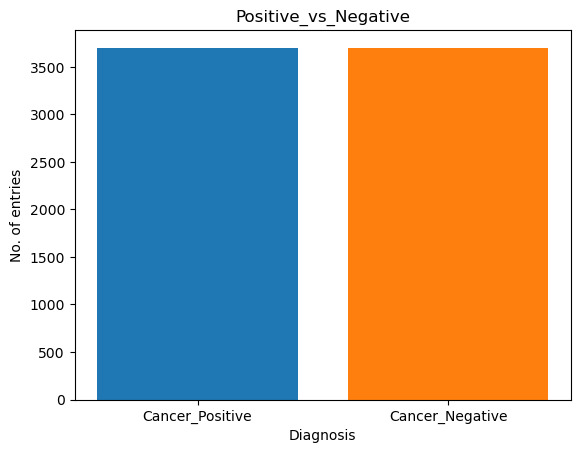

In [10]:
#plot of data
cancer_positive = len(cancer_train[cancer_train['cancer_negative'] == 0].index)
cancer_negative = len(cancer_train[cancer_train['cancer_negative'] == 1].index)
  
plt.bar('Cancer_Positive' ,cancer_positive, label= 'Positive')
plt.bar('Cancer_Negative' ,cancer_negative, label = 'Negative')
plt.xlabel("Diagnosis")
plt.ylabel("No. of entries")
plt.title("Positive_vs_Negative")
plt.show()

In [11]:
#add pathing to front of images in csv (chest_xrays/)
cancer_train['id'] = 'chest_xrays/' + cancer_train['id'].astype(str)
cancer_val['id'] = 'chest_xrays/' + cancer_val['id'].astype(str)
cancer_test['id'] = 'chest_xrays/' + cancer_test['id'].astype(str)

In [12]:
#adding entries from train to validation due to lack of entries
#adjust values
val_add = cancer_train[7000:7402]
cancer_train = cancer_train[0:7000]
cancer_val = cancer_val.append(val_add)
display(cancer_train)
display(cancer_val)

,id,cancer_negative,cancer_positive
47258,chest_xrays/00018964_011.png,0,1
16516,chest_xrays/00006948_001.png,0,1
3399,chest_xrays/00001577_004.png,1,0
31903,chest_xrays/00012758_000.png,0,1
1362,chest_xrays/00000643_001.png,1,0
...,...,...,...
21767,chest_xrays/00008943_002.png,0,1
58823,chest_xrays/00025543_010.png,0,1
67795,chest_xrays/00030586_000.png,0,1
2899,chest_xrays/00001344_000.png,1,0


,id,cancer_negative,cancer_positive
151,chest_xrays/00004436_001.png,0,1
138,chest_xrays/00015196_000.png,0,1
157,chest_xrays/00007454_002.png,0,1
156,chest_xrays/00007454_001.png,0,1
137,chest_xrays/00004532_003.png,0,1
...,...,...,...
20002,chest_xrays/00008230_030.png,0,1
17466,chest_xrays/00007230_000.png,0,1
4914,chest_xrays/00002143_001.png,1,0
47255,chest_xrays/00018964_001.png,0,1


In [13]:
columns = ['cancer_negative', 'cancer_positive'] 

In [14]:
#preprocessing and splitting of train and test data
Train_Generator = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.3,
                                    zoom_range=0.2,
                                    brightness_range=[0.2,0.9],
                                    rotation_range=30,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="nearest",
                                    validation_split=0.1)

In [15]:
#preprocessing of training images
Train_IMG_Set = Train_Generator.flow_from_dataframe(dataframe=cancer_train,
                                                   x_col="id",
                                                   y_col=columns, #can add more categories here
                                                   color_mode="rgb",
                                                   class_mode="raw",
                                                   batch_size=50,
                                                   subset="training")

Found 6300 validated image filenames.


In [16]:
Validation_Generator = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.3,
                                    zoom_range=0.2,
                                    brightness_range=[0.2,0.9],
                                    rotation_range=30,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="nearest",
                                    validation_split=0.1)

In [17]:
#preprocessing of validation images
Validation_IMG_Set = Validation_Generator.flow_from_dataframe(dataframe=cancer_val,
                                                   x_col="id",
                                                   y_col=columns,
                                                   color_mode="rgb",
                                                   class_mode="raw",
                                                   batch_size=100,
                                                   subset="validation")

Found 44 validated image filenames.


In [18]:
Test_Generator = ImageDataGenerator(rescale=1./255)

In [19]:
#preprocessing of testing images
Test_IMG_Set = Test_Generator.flow_from_dataframe(dataframe=cancer_test,
                                                 x_col="id",
                                                 y_col=columns,
                                                 color_mode="rgb",
                                                 class_mode="raw",
                                                 batch_size=100)

Found 1969 validated image filenames.


In [20]:
import keras,os
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D

In [21]:
input_shape = (256,256,3)

alex_net = Sequential()
# 1st convolution layer
alex_net.add(Conv2D(filters=96,input_shape=input_shape, activation="relu", padding="same", kernel_size=(11,11), strides=(4,4)))
# Max Pooling
alex_net.add(MaxPooling2D(pool_size=(3,3), padding="same", strides=(2,2))) 

# 2nd convolution layer
alex_net.add(Conv2D(filters=256, activation="relu", padding="same", kernel_size=(5,5), strides=(1,1))) 
# Max Pooling
alex_net.add(MaxPooling2D(pool_size=(3,3), padding="same", strides=(2,2)))

# 3rd convolution layer
alex_net.add(Conv2D(filters=384, activation="relu", padding="same", kernel_size=(3,3), strides=(1,1))) 

# 4th convolution layer
alex_net.add(Conv2D(filters=384, activation="relu", padding="same", kernel_size=(3,3), strides=(1,1))) 

# 5th convolution layer
alex_net.add(Conv2D(filters=256, activation="relu", padding="same", kernel_size=(3,3), strides=(1,1))) 
# Max Pooling
alex_net.add(MaxPooling2D(pool_size=(3,3), padding="same", strides=(2,2))) 

# flatten model
alex_net.add(Flatten())

# 1st fully connected layer 
alex_net.add(Dense(4096, activation="relu"))
# Add dropout layer
alex_net.add(Dropout(0.5))

# 2nd fully connected layer 
alex_net.add(Dense(4096, activation="relu"))
# Add dropout layer
alex_net.add(Dropout(0.5))

# Add output layer
alex_net.add(Dense(2, activation="softmax")) 
alex_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 384)       1

In [22]:
from keras.optimizers import Adam
opt = Adam(lr=0.001)
alex_net.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [23]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("alex_net_even.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
hist = alex_net.fit_generator(steps_per_epoch=100,generator=Train_IMG_Set, validation_data= Validation_IMG_Set, validation_steps=10,epochs=20,callbacks=[checkpoint,early])

Epoch 1/20
100/100 [==============================] - 571s 6s/step - loss: 0.9274 - accuracy: 0.5010 - val_loss: 0.6888 - val_accuracy: 0.6818
Epoch 2/20
100/100 [==============================] - 545s 5s/step - loss: 0.6937 - accuracy: 0.4924
Epoch 3/20
100/100 [==============================] - 545s 5s/step - loss: 0.6935 - accuracy: 0.4860
Epoch 4/20
100/100 [==============================] - 548s 5s/step - loss: 0.6931 - accuracy: 0.5124
Epoch 5/20
100/100 [==============================] - 536s 5s/step - loss: 0.6934 - accuracy: 0.4994
Epoch 6/20
100/100 [==============================] - 538s 5s/step - loss: 0.6934 - accuracy: 0.4942
Epoch 7/20
100/100 [==============================] - 538s 5s/step - loss: 0.6937 - accuracy: 0.4886
Epoch 8/20
100/100 [==============================] - 539s 5s/step - loss: 0.6930 - accuracy: 0.5088
Epoch 9/20
100/100 [==============================] - 546s 5s/step - loss: 0.6934 - accuracy: 0.4960
Epoch 10/20
100/100 [============================

In [24]:
alex_net.save('alex_net_even.h5')

In [25]:
from keras.models import load_model
model = load_model("alex_net_even.h5")

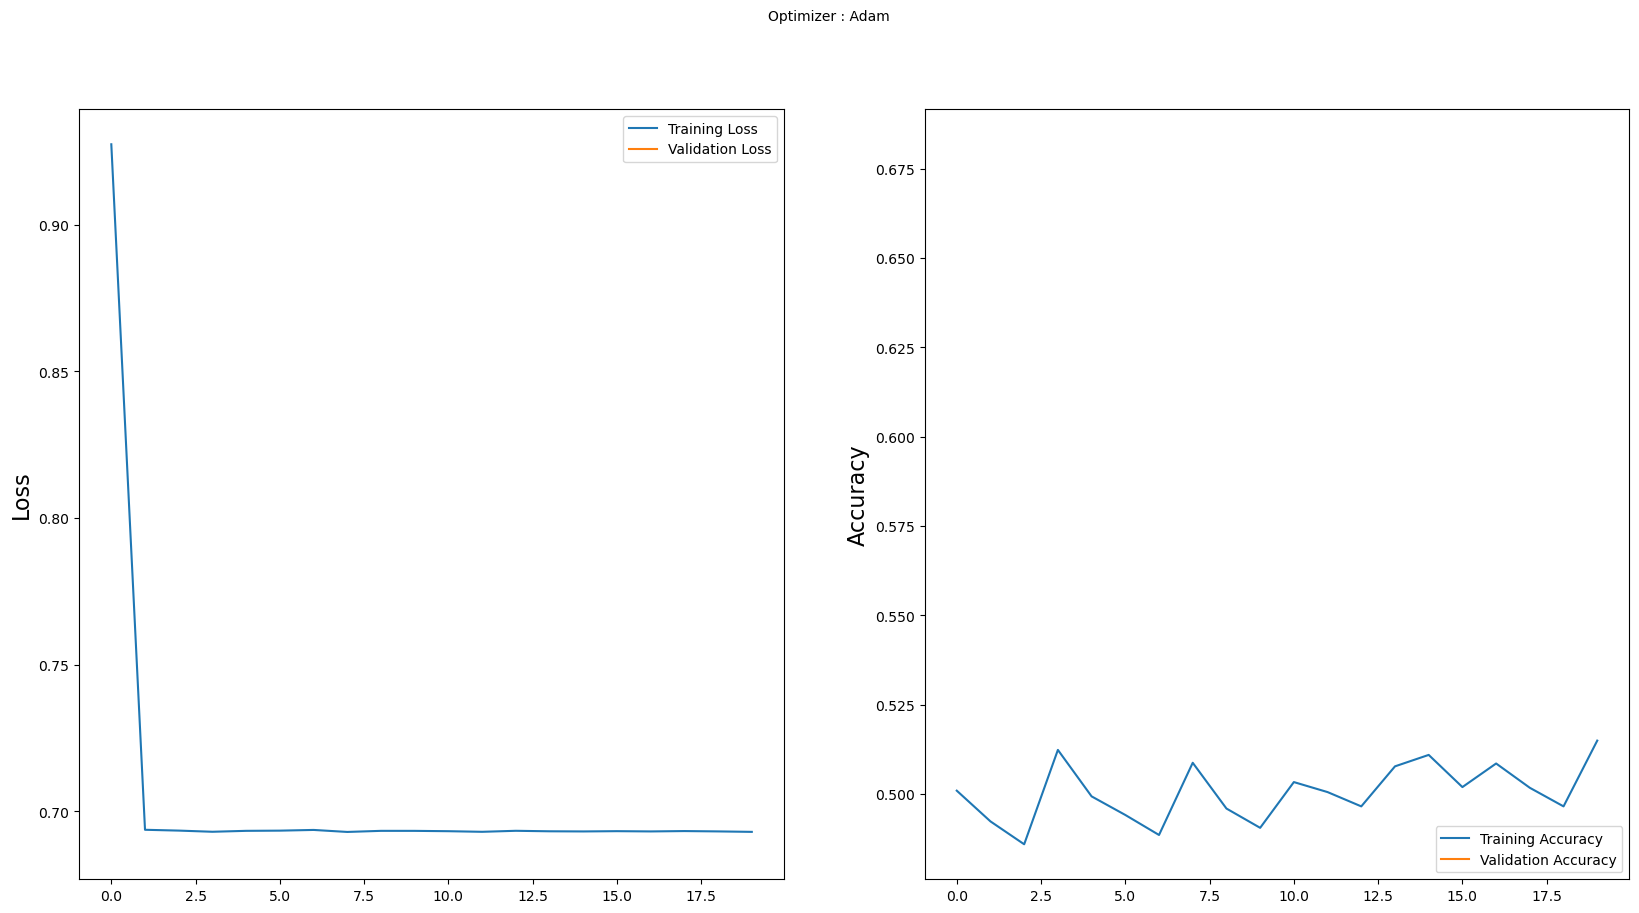

In [26]:
#plotting accuracy and loss
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [44]:
#validation
results_val = model.evaluate(Validation_IMG_Set)
preds_val   = model.predict(Validation_IMG_Set)
print('The current model achieved a categorical accuracy of {}%!'.format(round(results_val[1]*100,2)))

1/1 [==============================] - 5s 5s/step
The current model achieved a categorical accuracy of 68.18%!


In [45]:
#testing results
results = model.evaluate(Test_IMG_Set)
preds   = model.predict(Test_IMG_Set)
print('The current model achieved a categorical accuracy of {}%!'.format(round(results[1]*100,2)))

20/20 [==============================] - 99s 5s/step
The current model achieved a categorical accuracy of 49.21%!


In [46]:
#storing test predictions
Prediction_One = model.predict(Test_IMG_Set)
Prediction_One = Prediction_One.argmax(axis=-1)
#Predict_Class = (model.predict(Test_IMG_Set) > 0.5).astype("int64")
Predict_Class = np.argmax(model.predict(Test_IMG_Set),axis=1)

20/20 [==============================] - 96s 5s/step


In [47]:
import math

In [48]:
test_batches = Test_Generator.flow_from_dataframe(dataframe = cancer_test, x_col="id", y_col="cancer_positive", class_mode="raw", batch_size=100)
number_of_examples = len(Test_IMG_Set.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 100)) 
# 1.0 above is to skip integer division

For_Prediction_Class = []

for i in range(0,int(number_of_generator_calls)):
    For_Prediction_Class.extend(np.array(test_batches[i][1]))

Found 1969 validated image filenames.


In [49]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve

In [50]:
#confusion matrix and other metrics
print(confusion_matrix(For_Prediction_Class,Predict_Class))
print(classification_report(For_Prediction_Class,Predict_Class))

[[   0 1000]
 [   0  969]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.49      1.00      0.66       969

    accuracy                           0.49      1969
   macro avg       0.25      0.50      0.33      1969
weighted avg       0.24      0.49      0.32      1969



In [ ]:
#call saved model
#using an input run it on saved model
#model can predict cancerous or no cancerous
#same bounding boxes